In [2]:
import folium
import polyline
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import branca.colormap as cm
import os
import json
import h5py

# Step 1: Load the data
# Load edge features
edge_features = pd.read_csv("../highway_network/edge_features.csv")

# Load traffic volume data and average over the years, ignoring NaN values
with h5py.File("average_daily_volumes_2015-2022.h5", "r") as f:
    data = f["data"][:]
    gt = np.nanmean(data, axis=0)  # Average over 8 years, ignoring NaNs (shape: 498,)


In [3]:
edge_features.head()

,Id,Name,Description,Longitude,Latitude,Status,Origin,Destination,Comment,Distance (km),Duration (s),Polyline,Straight_line_distance,Detour_factor,Average_speed (km/h)
0,8825,TMU Site 9755/2 on link A1 northbound between ...,9755/2,-1.712094,55.264736,Active,1,0,NaN,103.415,4301.0,agrnIv`jIIJi@fDu@zG\HVCf@Qd@s@RQd@Kz@\xAnAhElB...,91.303340,1.132653,86.559870
1,8826,TMU Site 9755/1 on link A1 southbound between ...,9755/1,-1.712031,55.264763,Active,0,1,NaN,102.538,4232.0,ainsIhpiKRR|ElIfDjG~FrL|C`HbCrGfBfFHf@jMh_@hFf...,91.303340,1.123048,87.225142
2,8851,TMU Site 9817/2 on A69 eastbound between B6322...,9817/2,-2.396705,54.971136,Active,2,1,NaN,84.922,3771.0,iw`nI|bsP_@{@_@i@U{@KoACwBF{@Fe@Tg@TiAHgAAwA]a...,77.104500,1.101388,81.071122
3,8852,TMU Site 9817/1 on link A69 westbound between ...,9817/1,-2.396689,54.971092,Active,1,2,NaN,85.209,3820.0,agrnIv`jIIJi@fDu@zGUI[LaAlHgBdP}@fJYtBmA~LoDnc...,77.104500,1.105111,80.301675
4,8744,TMU Site 9502/1 on link M6 northbound between ...,9502/1,-3.002612,54.969402,Active,2,3,NaN,15.644,548.0,iw`nI|bsP_@{@_@i@u@c@mCWqE[wDBeH`@oCRQEaIxAaCp...,14.647104,1.068061,102.770803


In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import polyline

# Step 1: Decode Google Polylines
def decode_google_polyline(polyline_str):
    """
    Decodes a Google Maps polyline string into a Shapely LineString geometry.
    """
    coords = polyline.decode(polyline_str)  # Returns a list of (lat, lon) tuples
    return LineString([(lon, lat) for lat, lon in coords])  # Convert to (lon, lat)

# Apply decoding to create geometry column
edge_features['geometry'] = edge_features['Polyline'].apply(decode_google_polyline)

# Step 2: Create GeoDataFrame
gdf = gpd.GeoDataFrame(edge_features, geometry='geometry', crs="EPSG:4326")

# Step 3: Add traffic volume from `gt` array
gdf['TrafficVolume'] = gt

# Aggregate traffic volume for OD-DO pairs
gdf['ODPair'] = gdf[['Origin', 'Destination']].apply(lambda x: tuple(sorted(x)), axis=1)
avg_volume = gdf.groupby('ODPair')['TrafficVolume'].mean().reset_index()
gdf = gdf.merge(avg_volume, on='ODPair', suffixes=('', '_Mean'))

# Keep one geometry per OD pair
gdf = gdf.drop_duplicates(subset='ODPair')
gdf = gdf[gdf['TrafficVolume_Mean'].notna()]  # Remove rows with NA values

# Step 4: Normalize traffic volume for color mapping
gdf['NormalizedVolume'] = (gdf['TrafficVolume_Mean'] - gdf['TrafficVolume_Mean'].min()) / (
    gdf['TrafficVolume_Mean'].max() - gdf['TrafficVolume_Mean'].min()
)

# Step 5: Reproject to EPSG:27700 (British National Grid)
gdf = gdf.to_crs("EPSG:27700")

C:\Users\yueli\AppData\Local\Temp\ipykernel_23328\1483997195.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f"{int(x/1000)}" for x in cbar.get_ticks()])


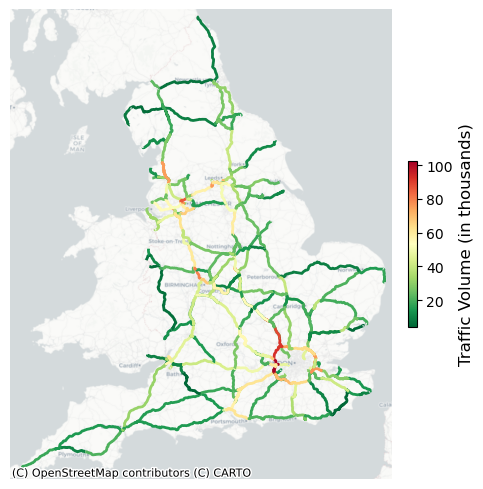

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create a single figure for the traffic volume map
fig, ax = plt.subplots(figsize=(5, 5))

# Plot traffic volume with color based on NormalizedVolume
gdf.plot(ax=ax, column='NormalizedVolume', cmap='RdYlGn_r', linewidth=2, legend=False)

# Add a basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Adjust map extent to fit the data
ax.set_xlim(gdf.total_bounds[0] - 10000, gdf.total_bounds[2] + 10000)
ax.set_ylim(gdf.total_bounds[1] - 10000, gdf.total_bounds[3] + 10000)

# Add a custom colorbar
norm = mpl.colors.Normalize(vmin=gdf['TrafficVolume_Mean'].min(), vmax=gdf['TrafficVolume_Mean'].max())
sm = mpl.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm._A = []  # Necessary to avoid a matplotlib warning
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.ax.set_yticklabels([f"{int(x/1000)}" for x in cbar.get_ticks()])
cbar.set_label('Traffic Volume (in thousands)', fontsize=12)

# Title for the map
# ax.set_title('Traffic Volume Across England', fontsize=16)
ax.axis('off')

# Adjust layout for clarity
plt.tight_layout()
plt.savefig('Traffic_volume_map.png')
plt.show()

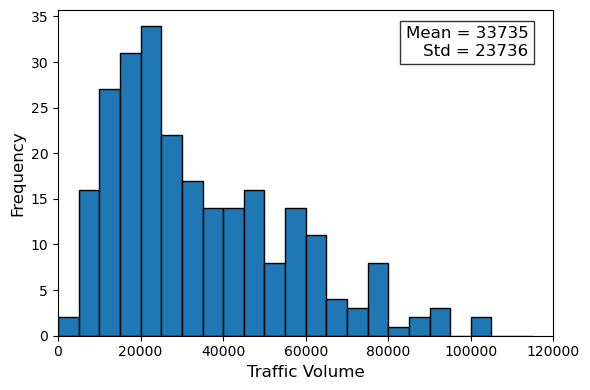

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure for the histogram
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram with the specified color
ax.hist(
    gdf['TrafficVolume_Mean'], 
    bins=np.arange(0, 120000, 5000), 
    color='#1F77B4',  # RGB color as hex
    edgecolor='black'
)

# Set labels
ax.set_xlabel('Traffic Volume', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Set x-axis limits (e.g., 0 to 120,000)
ax.set_xlim(0, 120000)

# Format x-axis in thousands
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f"{int(x)}" for x in ax.get_xticks()])

# Add text block with Mean and Std
mean_value = 33735
std_value = 23736
text = f"Mean = {mean_value}\nStd = {std_value}"
ax.text(
    0.95, 0.95, text, 
    transform=ax.transAxes, 
    fontsize=12, 
    verticalalignment='top', 
    horizontalalignment='right', 
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Adjust layout for clarity
plt.tight_layout()

# Save the figure and show
plt.savefig('Traffic_volume_hist.png')
plt.show()